In [5]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
import torch
import matplotlib.pyplot as plt
from seagul.mesh import create_mesh, variation_dim, mesh_dim, create_box_mesh
import time
import copy
import gym
import torch

import xarray as xr
import numpy as np
import pandas as pd

import os

In [42]:
def identity(rews,obs,acts):
    return rews

def vardiv(rews, obs, acts):
    return rews/variation_dim(obs)

def varmul(rews, obs, acts):
    return rews*variation_dim(obs)

def rough_measure(x):
    d = torch.stack([x[t,:] - x[t-1,:] for t in range(1,x.shape[0])])
    return d.std()#$/(torch.abs(d.mean()))

def rmul(rews, obs, acts):
    return rews*rough_measure(obs)

def rdiv(rews, obs, acts):
    return rews/rough_measure(obs)

def pcastd(rews, obs, acts):
    pca = PCA()
    pca.fit((obs - obs.mean())/obs.std())
    return rews*pca.explained_variance_ratio_.std()


def mdim_mul(rews, obs, acts):
    m,_,_,_ = mesh_dim(obs)
    return m*rews

def mdim_div(rews, obs, acts):
    m,_,_,_ = mesh_dim(obs)
    return rews/m

def cdim_mul(rews, obs, acts):
    _,c,_,_ = mesh_dim(obs)
    return c*rews

def cdim_div(rews, obs, acts):
    _,c,_,_ = mesh_dim(obs)
    return rews/c


def madodiv(rews, obs, acts):
    return rews/variation_dim(obs, order=1)

def variodiv(rews, obs, acts):
    return rews/variation_dim(obs, order=2)

def rododiv(rews, obs, acts):
    return rews/variation_dim(obs, order=.5)



def do_rollout(env, policy, render=False):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while not done:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        if render:
            env.render()
            time.sleep(.05)

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length


def do_long_rollout(env, policy, ep_length):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while cur_step < ep_length:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length

# Data 4 identity, vardiv, rmul

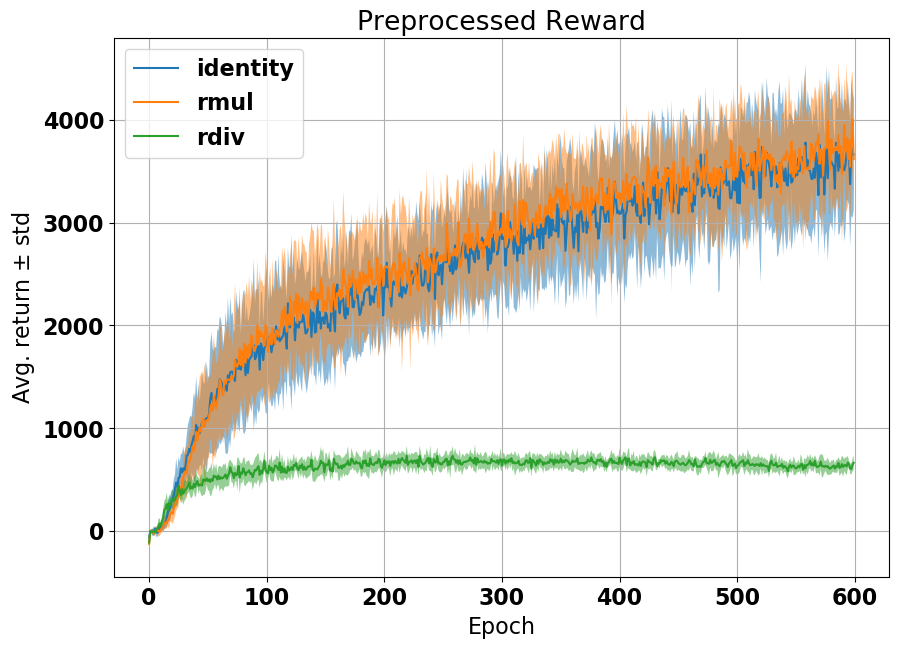

<Figure size 640x480 with 0 Axes>

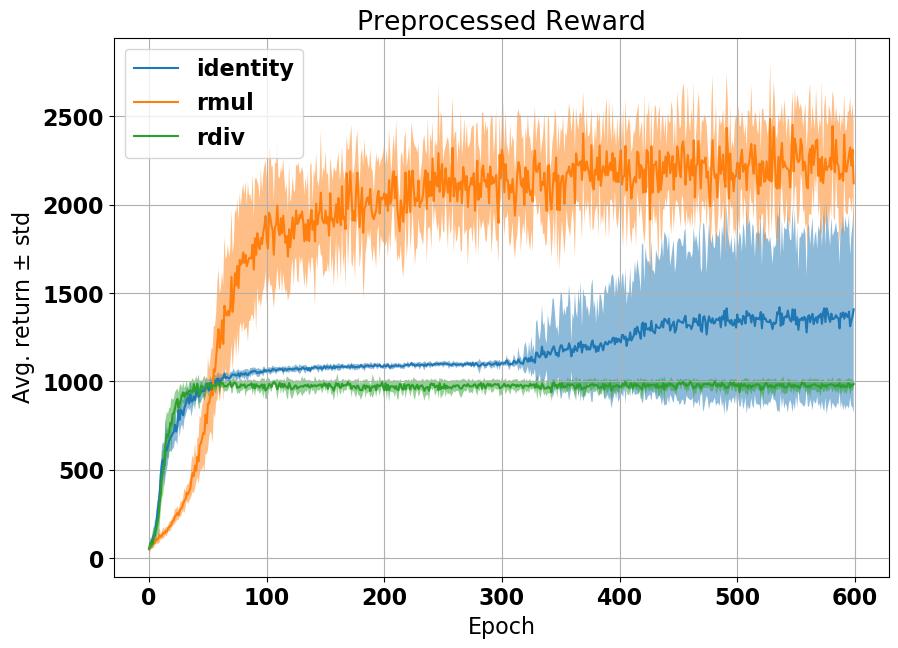

<Figure size 640x480 with 0 Axes>

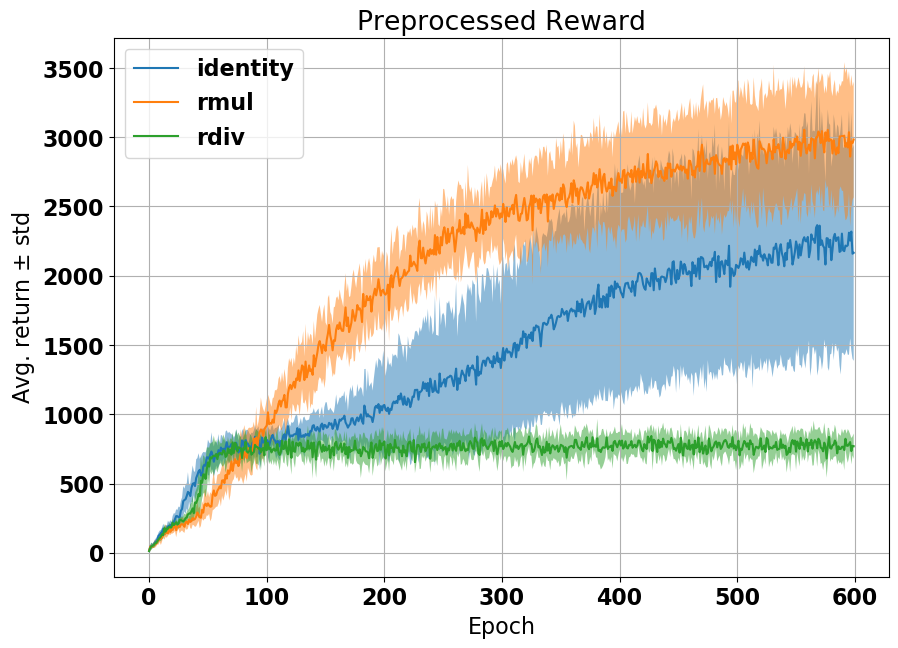

<Figure size 640x480 with 0 Axes>

In [111]:
# #data = torch.load("./datacdim2/Hopper-v2.xr")
# env_names = ['Walker2d-v2', 'Hopper-v2', 'HalfCheetah-v2']
# for env_name in env_names:
#     data = torch.load(f"./data4/{env_name}.xr")

#     policy_dict = data.policy_dict
#     rews = data.rews#/data.post_rews
#     exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
#     num_seeds = len(policy_dict[exp_names[0]])

#     means = rews.mean(dim="trial")
#     stds = rews.std(dim="trial")

#     plt.plot(means.T)
#     plt.legend(exp_names)
#     ci = stds

#     for mean, c in zip(means, ci):
#         plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
#     plt.title(f"Preprocessed Reward {env_name}")
#     plt.figure()

#     # for exp_name in exp_names:  
#     #     plt.plot(rews.loc[exp_name].T[:,0:10])
#     #     plt.title(exp_name)
#     #     plt.figure()
#     # top_seeds = {'identity':[0,1], 'cdim_div':[0,1]}
    
    
import matplotlib

#matplotlib.style.use('seaborn')
matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)


#data = torch.load("./datacdim2/Hopper-v2.xr")
env_names = ['HalfCheetah-v2', 'Hopper-v2', 'Walker2d-v2']
for env_name in env_names:
    #data = torch.load(f"./data4/{env_name}.xr").where(data.post!='radodiv')
    data = torch.load(f"./data4/{env_name}.xr")

    policy_dict = data.policy_dict
    rews = data.rews.loc[['identity', 'rmul', 'rdiv']]#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    plt.subplots(1,1, figsize=(10,7))
    plt.plot(means.T)
    plt.legend(exp_names, loc='upper left')
    ci = stds

    for mean, c in zip(means, ci):
        plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
    plt.title(f"Preprocessed Reward")
    plt.ylabel(r"Avg. return $\pm$ std")
    plt.xlabel(r"Epoch")
    plt.grid()
    plt.figure()

#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.title(exp_name)
#         plt.figure()
#     top_seeds = {'identity':[0,1], 'cdim_div':[0,1]}

In [113]:
for env_name in env_names:
    env = gym.make(env_name)
    data = torch.load(f"./data4/{env_name}.xr")
    policy_dict = data.policy_dict
    init_d = 1e-6
    num_runs = 5; num_seeds=10
    post_fns = [identity, vardiv, rmul, rdiv]
    ep_length= 1000


    mshdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    rews =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    for post_fn in post_fns:
        for i in range(num_seeds):
            for j in range(num_runs):
                policy = policy_dict[post_fn.__name__][i]
                o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
                target = o[200:]
                target = (target - policy.state_means)/(policy.state_std)
                #target = (target - target.mean(dim=0))/(target.std(dim=0))


                rews.loc[post_fn.__name__,i,j] = sum(r).item()

                #mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d)
                #mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
                #vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
                #rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                

    print(f"{env_name}:")           
    print("madogram dimension")
    for fn in post_fns:
        mean = mdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = mdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for fn in post_fns:
        mean = vdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = vdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("radogram dimension")
    for fn in post_fns:
        mean = rdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = rdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for fn in post_fns:
        mean = mshdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = mshdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for fn in post_fns:
        mean = cdims.mean(dim=('seed', 'run')).loc[fn.__name__].item()
        std = cdims.std(dim=('seed', 'run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for fn in post_fns:
        mean = rews.mean(dim=('seed', 'run')).loc[fn.__name__].item()
        std = rews.std(dim=('seed', 'run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print(); print()


HalfCheetah-v2:
madogram dimension
identity mean: 0.0, std: 0.0
vardiv mean: 0.0, std: 0.0
rmul mean: 0.0, std: 0.0
rdiv mean: 0.0, std: 0.0

variogram dimension
identity mean: 0.0, std: 0.0
vardiv mean: 0.0, std: 0.0
rmul mean: 0.0, std: 0.0
rdiv mean: 0.0, std: 0.0

radogram dimension
identity mean: 0.0, std: 0.0
vardiv mean: 0.0, std: 0.0
rmul mean: 0.0, std: 0.0
rdiv mean: 0.0, std: 0.0

mesh dimension
identity mean: 0.0, std: 0.0
vardiv mean: 0.0, std: 0.0
rmul mean: 0.0, std: 0.0
rdiv mean: 0.0, std: 0.0

cmesh dimension
identity mean: 0.0, std: 0.0
vardiv mean: 0.0, std: 0.0
rmul mean: 0.0, std: 0.0
rdiv mean: 0.0, std: 0.0

rewards
identity mean: 5171.34353515625, std: 891.6793286790672
vardiv mean: 4806.736181640625, std: 749.8389790190996
rmul mean: 4965.533188476563, std: 844.4529514078879
rdiv mean: 876.7103991699219, std: 81.62290070913164


Hopper-v2:
madogram dimension
identity mean: 0.0, std: 0.0
vardiv mean: 0.0, std: 0.0
rmul mean: 0.0, std: 0.0
rdiv mean: 0.0, std: 0

In [ ]:

print(f"{env_name}:")           
print("madogram dimension")
for fn in post_fns:
    mean = mdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = mdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

print()
print("variogram dimension")
for fn in post_fns:
    mean = vdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = vdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

print()
print("radogram dimension")
for fn in post_fns:
    mean = rdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = rdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

print()
print("mesh dimension")
for fn in post_fns:
    mean = mshdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = mshdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

print()
print("cmesh dimension")
for fn in post_fns:
    mean = cdims.mean(dim=('seed', 'run')).loc[fn.__name__].item()
    std = cdims.std(dim=('seed', 'run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

print()
print("rewards")
for fn in post_fns:
    mean = rews.mean(dim=('seed', 'run')).loc[fn.__name__].item()
    std = rews.std(dim=('seed', 'run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

print(); print()

# Data 17

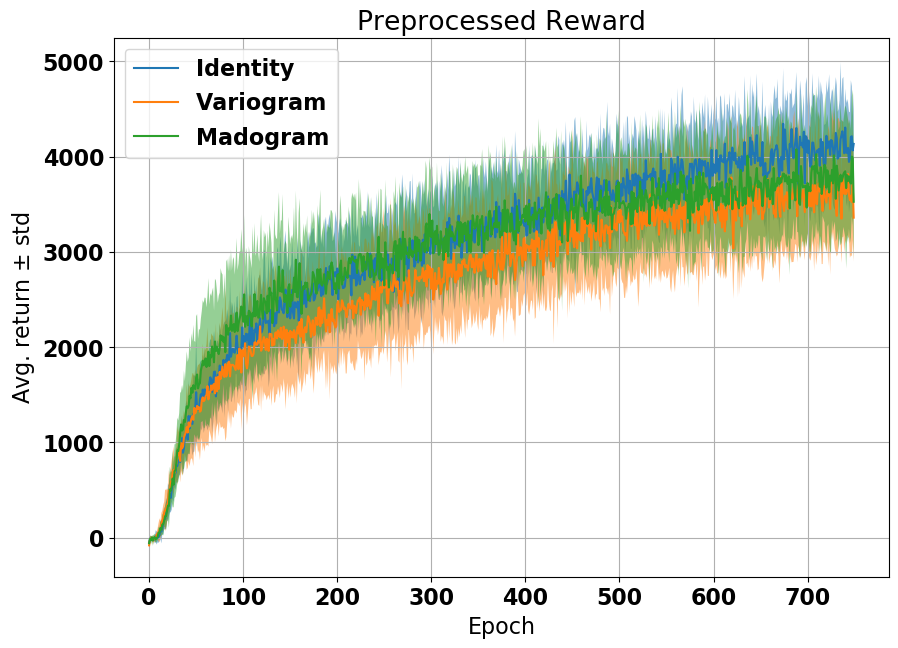

<Figure size 640x480 with 0 Axes>

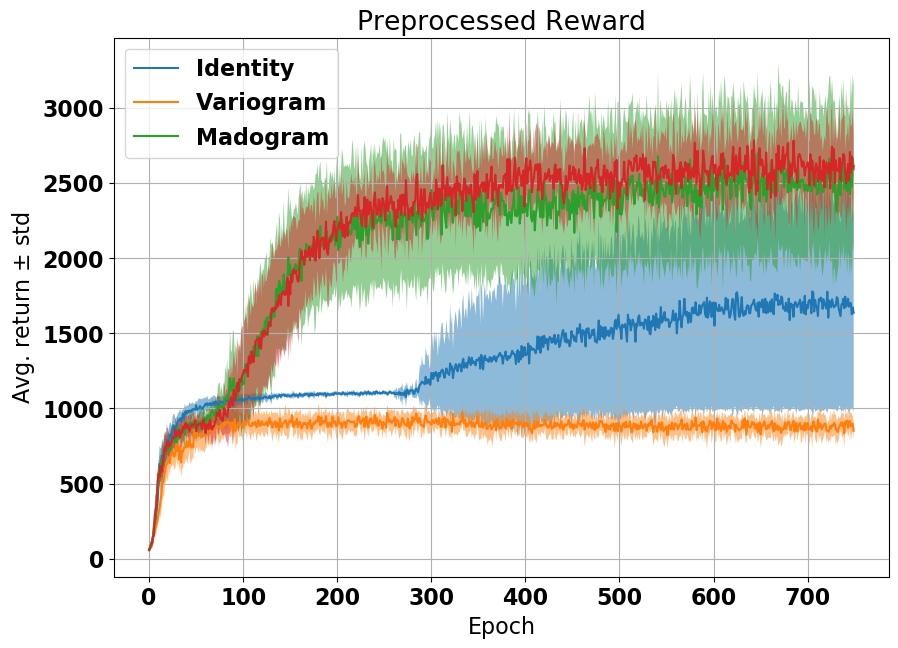

<Figure size 640x480 with 0 Axes>

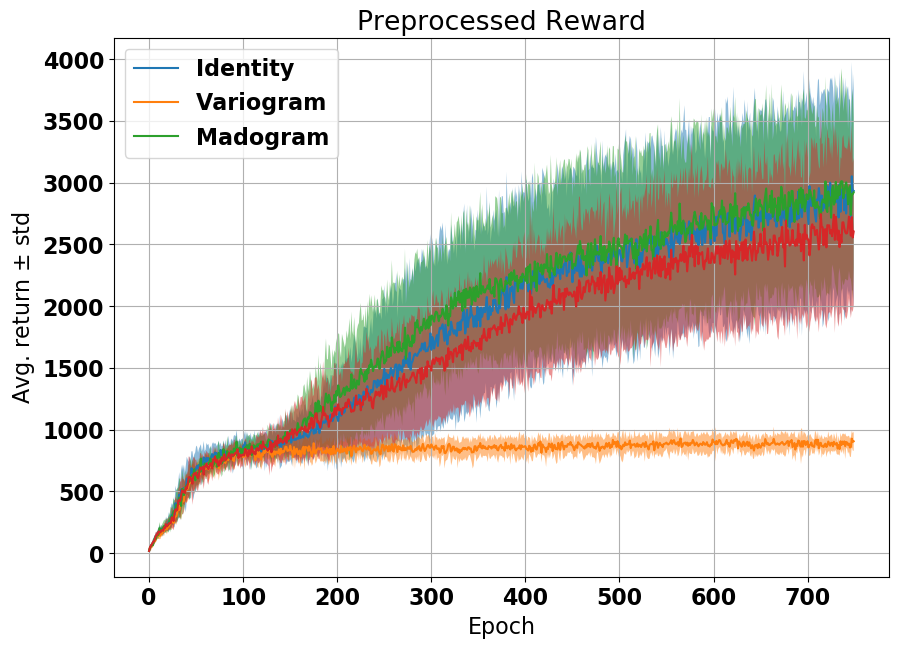

<Figure size 640x480 with 0 Axes>

In [125]:
import matplotlib

#matplotlib.style.use('seaborn')
matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)


#data = torch.load("./datacdim2/Hopper-v2.xr")
env_names = ['HalfCheetah-v2', 'Hopper-v2', 'Walker2d-v2']
for env_name in env_names:
    data = torch.load(f"./data17/{env_name}.xr")
    #data = data.where(data.post!='radodiv')

    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    plt.subplots(1,1, figsize=(10,7))
    plt.plot(means.T)
    plt.legend(['Identity', 'Variogram','Madogram'], loc='upper left')
    ci = stds

    for mean, c in zip(means, ci):
        plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
    plt.title(f"Preprocessed Reward")
    plt.ylabel(r"Avg. return $\pm$ std")
    plt.xlabel(r"Epoch")
    plt.grid()
    plt.figure()

#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.title(exp_name)
#         plt.figure()
#     top_seeds = {'identity':[0,1], 'cdim_div':[0,1]}

In [127]:
for env_name in env_names:
    env = gym.make(env_name)
    data = torch.load(f"./data17/{env_name}.xr")
    policy_dict = data.policy_dict
    init_d = 1e-6
    num_runs = 5; num_seeds=10
    post_fns = [identity, variodiv, madodiv]
    ep_length= 1000


    mshdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    rews =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                    dims = ("post", "seed", "run"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

    for post_fn in post_fns:
        for i in range(num_seeds):
            for j in range(num_runs):
                policy = policy_dict[post_fn.__name__][i]
                o,a,r,l = do_long_rollout(env, policy, ep_length=ep_length)
                target = o[200:]
                target = (target - policy.state_means)/(policy.state_std)
                #target = (target - target.mean(dim=0))/(target.std(dim=0))


                rews.loc[post_fn.__name__,i,j] = sum(r).item()

#                 mshdims.loc[post_fn.__name__,i,j], cdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d)
#                 mdims.loc[post_fn.__name__,i,j] = variation_dim(target)
#                 vdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=2)
#                 rdims.loc[post_fn.__name__,i,j] = variation_dim(target,order=.5)
                

    print(f"{env_name}:")           
    print("madogram dimension")
    for fn in post_fns:
        mean = mdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = mdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("variogram dimension")
    for fn in post_fns:
        mean = vdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = vdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("rodogram dimension")
    for fn in post_fns:
        mean = rdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = rdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("mesh dimension")
    for fn in post_fns:
        mean = mshdims.mean(dim=('seed','run')).loc[fn.__name__].item()
        std = mshdims.std(dim=('seed','run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("cmesh dimension")
    for fn in post_fns:
        mean = cdims.mean(dim=('seed', 'run')).loc[fn.__name__].item()
        std = cdims.std(dim=('seed', 'run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print()
    print("rewards")
    for fn in post_fns:
        mean = rews.mean(dim=('seed', 'run')).loc[fn.__name__].item()
        std = rews.std(dim=('seed', 'run')).loc[fn.__name__].item()
        print(f"{fn.__name__} mean: {mean}, std: {std}")

    print(); print()

HalfCheetah-v2:
madogram dimension
identity mean: 0.0, std: 0.0
variodiv mean: 0.0, std: 0.0
madodiv mean: 0.0, std: 0.0

variogram dimension
identity mean: 0.0, std: 0.0
variodiv mean: 0.0, std: 0.0
madodiv mean: 0.0, std: 0.0

rodogram dimension
identity mean: 0.0, std: 0.0
variodiv mean: 0.0, std: 0.0
madodiv mean: 0.0, std: 0.0

mesh dimension
identity mean: 0.0, std: 0.0
variodiv mean: 0.0, std: 0.0
madodiv mean: 0.0, std: 0.0

cmesh dimension
identity mean: 0.0, std: 0.0
variodiv mean: 0.0, std: 0.0
madodiv mean: 0.0, std: 0.0

rewards
identity mean: 5545.999619140625, std: 593.8769940808644
variodiv mean: 5136.002861328125, std: 851.9177511359011
madodiv mean: 5234.127109375, std: 950.6454916922088


Hopper-v2:
madogram dimension
identity mean: 0.0, std: 0.0
variodiv mean: 0.0, std: 0.0
madodiv mean: 0.0, std: 0.0

variogram dimension
identity mean: 0.0, std: 0.0
variodiv mean: 0.0, std: 0.0
madodiv mean: 0.0, std: 0.0

rodogram dimension
identity mean: 0.0, std: 0.0
variodiv me

In [11]:
print("madogram dimension")
for fn in post_fns:
    mean = mdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = mdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")
    
print("variogram dimension")
for fn in post_fns:
    mean = vdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = vdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")
    
print("radogram dimension")
for fn in post_fns:
    mean = rdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = rdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")
    
print("mesh dimension")
for fn in post_fns:
    mean = mshdims.mean(dim=('seed','run')).loc[fn.__name__].item()
    std = mshdims.std(dim=('seed','run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")
    
print("cmesh dimension")
for fn in post_fns:
    mean = cdims.mean(dim=('seed', 'run')).loc[fn.__name__].item()
    std = cdims.std(dim=('seed', 'run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

print("rewards")
for fn in post_fns:
    mean = rews.mean(dim=('seed', 'run')).loc[fn.__name__].item()
    std = rews.std(dim=('seed', 'run')).loc[fn.__name__].item()
    print(f"{fn.__name__} mean: {mean}, std: {std}")

madogram dimension
identity mean: 1.3641815562845463, std: 0.7131068597308426
madodiv mean: 1.0675124236696034, std: 0.025928685628854364
variodiv mean: 1.0736164598272016, std: 0.014621378083432406
radodiv mean: 1.0100997017728703, std: 0.0022356151543227415
variogram dimension
identity mean: 1.6820907781422727, std: 0.3565534298654213
madodiv mean: 1.5337562118348018, std: 0.012964342814427186
variodiv mean: 1.5368082299136008, std: 0.007310689041716207
radodiv mean: 1.5050498508864354, std: 0.0011178075771613861
radogram dimension
identity mean: 0.7283631125690928, std: 1.4262137194616853
madodiv mean: 0.13502484733920697, std: 0.05185737125770877
variodiv mean: 0.14723291965440297, std: 0.02924275616686483
radodiv mean: 0.02019940354574067, std: 0.004471230308645463
mesh dimension
identity mean: 2.124332089328673, std: 0.2919824812804116
madodiv mean: 1.9424969000840988, std: 0.5627058442203654
variodiv mean: 1.9668335305290916, std: 0.4070631199401695
radodiv mean: 1.2004352865998

In [ ]:
print("vdim mean: \n", vdims.mean(dim='seed').to_series(), "\n")
print("vdim std: \n" , vdims.std(dim='seed').to_series(), "\n")

In [ ]:
print("mdim mean: \n", mdims.mean(dim='seed').to_series(), "\n")
print("mdim std: \n" , mdims.std(dim='seed').to_series(), "\n")

In [ ]:
print("cdim mean: \n", cdims.mean(dim='seed').to_series(), "\n")
print("cdim std: \n" , cdims.std(dim='seed').to_series(), "\n")

In [ ]:
from seagul.mesh import create_mesh_dict

In [79]:
env_name = "Hopper-v2"
data = torch.load(f"./data17/{env_name}.xr")

policy_dict = data.policy_dict
rews = data.rews#/data.post_rews
exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict[exp_names[0]])
env = gym.make(env_name)

for post_name in ['identity', 'madodiv', 'variodiv', 'radodiv']: #seed = 10
    for seed in range(num_seeds):
        for run in [0,1,2,3,4]:
            o,a,r,l = do_long_rollout(env,policy_dict[post_name][seed], ep_length=10000)

            #print("reward:", sum(r))
            #print("variation_dim: ", variation_dim(o))
            #print("roughness: ", rough_measure(o))
            #plt.plot(o)
            #plt.figure()
            #plt.plot(a)

            import scipy.io 
            import os

            o = np.array(o)
            a = np.array(a)
            r = np.array(r)
            os.makedirs(f"./data/k2/env_{env_name}/post_{post_name}/seed_{seed}", exist_ok=True)
            scipy.io.savemat(f"./data/k2/env_{env_name}/post_{post_name}/seed_{seed}/run_{run}.mat", mdict = {"obs":o, "act":a, "rew":r})

KeyboardInterrupt: 

CPU times: user 275 ms, sys: 0 ns, total: 275 ms
Wall time: 274 ms
tensor([5475.4478])


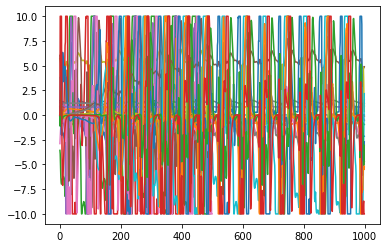

In [78]:
env_name = "Walker2d-v2"

seed = 0
policy = policy_dict['identity'][seed]
env = gym.make(env_name)
%time o,a,r,l = do_long_rollout(env, policy, ep_length= 1000)
#o,a,r,l = do_rollout(env, policy, render=True)
print(sum(r))
start_idx = 500
plt.plot(o[start_idx:])
target = o[start_idx:]
plt.plot(o)
scipy.io.savemat(f"./data/k2/env_{env_name}/post_{post_name}/seed_{seed}/video_demo.mat", mdict = {"obs":o, "act":a, "rew":r})

In [ ]:
def power_var(X, l, ord):
    # Implements the power variation, used for the variation fractal dimension
    return 1 / (2 * len(X) - l) * np.sum(np.linalg.norm(X[l:] - X[:-l],ord=ord))

def power_var(X, l, ord):
    diffs = X[l:] - X[:-l]
    norms = np.zeros(diffs.shape[0])
    for i,d in enumerate(diffs):
        norms[i] = np.linalg.norm(d,ord=1)
        
    return 1 / (2 * len(X) - l) * np.sum(norms)

def variation_dim(X, order=1):
    # Implements the order p variation fractal dimension from https://arxiv.org/pdf/1101.1444.pdf (eq 18)
    # order 1 corresponds to the madogram, 2 to the variogram, 1/2 to the rodogram
    return 2 - 1/(order*np.log(2))*(np.log(power_var(X, 2, order)) - np.log(power_var(X, 1, order)))

In [ ]:
def cdim_div(rews, obs, acts):
    _,c,_,_ = mesh_dim(obs)
    return rews/c
   

env_names = ["Walker2d-v2"]#,  "Hopper-v2", "HalfCheetah-v2"]#,  "linear_z2d-v0"]
post_fns = [cdim_div, identity]#, mdim_div]
#post_fns = [cdim_div]


torch.set_default_dtype(torch.float64)
num_experiments = len(post_fns)
num_seeds = 5
num_epochs = 250
n_workers = 12; n_delta = 60; n_top = 20; exp_noise=.025

init_data = torch.load("./data17/Walker2d-v2.xr")
init_policy_dict = init_data.policy_dict

save_dir = "./datacdim1/"
os.makedirs(save_dir)

import time
start = time.time()

env_config = {}
policy_dict[cdim_div.__name__] = [policy]

for env_name in env_names:
        env = gym.make(env_name, **env_config)
        in_size = env.observation_space.shape[0]
        out_size = env.action_space.shape[0]
        policy_dict =  {fn.__name__:[] for fn in post_fns}
        
        rewards = xr.DataArray(np.zeros((num_experiments, num_seeds, num_epochs)),
                    dims = ("post", "trial", "epoch"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

        post_rewards = xr.DataArray(np.zeros((num_experiments, num_seeds, num_epochs)),
                    dims = ("post", "trial", "epoch"),
                    coords = {"post": [fn.__name__ for fn in post_fns]})

        data = xr.Dataset(
            {"rews" : rewards,
            "post_rews" : post_rewards},
            coords = {"post": [fn.__name__ for fn in post_fns]},
            attrs  = {"policy_dict":policy_dict, "post_fns":post_fns, "env_name":env_name,
                      "hyperparams":{"num_experiments":num_experiments, "num_seeds":num_seeds, "num_epochs":num_epochs, "n_workers":n_workers, "n_delta":n_delta, "n_top":n_top, "exp_noise":exp_noise},
                      "env_config":env_config})             
            

        for post_fn in post_fns:
            for i in range(num_seeds):
                policy = init_policy_dict['identity'][i]
                policy, r_hist, lr_hist = ars(env_name, policy, num_epochs, n_workers=n_workers, n_delta=n_delta, n_top=n_top, exp_noise=exp_noise, postprocess=post_fn, env_config=env_config, zero_policy=False)
                print(f"{env_name}, {post_fn.__name__}, {i}, {time.time() - start}")
                data.policy_dict[post_fn.__name__].append(copy.deepcopy(policy))
                data.rews.loc[post_fn.__name__,i,:] = lr_hist
                data.post_rews.loc[post_fn.__name__,i,:] = r_hist

        torch.save(data, f"{save_dir}{env_name}.xr")


In [ ]:
o,a,r,l = do_long_rollout(env, policy, ep_length=10000)
target = o[200:]
target = (target - target.mean(dim=0))/target.std(dim=0)
m,c,d,l = mesh_dim(target)
print(m)
print(c)
